In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt # For accuracy plot
from tqdm.auto import tqdm # For progress bars
from data_loader import get_cifar100_loaders
from evaluation_utils import (evaluate_model, plot_confusion_matrix,
                              visualize_misclassified, get_cifar100_class_names)



In [2]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=100, input_size=32):
        super(CustomCNN, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 32x32 -> 16x16

        # Block 2
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 16x16 -> 8x8

        # Block 3
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 8x8 -> 4x4 (if input_size=32)

        # Calculate input features for FC layer based on input_size
        fc_input_features = 256 * (input_size // 8) * (input_size // 8)

        # Fully Connected Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(fc_input_features, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))
        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(F.relu(self.bn4(self.conv4(x))))
        # Block 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool3(F.relu(self.bn6(self.conv6(x))))

        # Fully Connected
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [3]:
def train_model(model, train_loader, test_loader, num_epochs, learning_rate, device, model_name="1_CustomCNN"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    model.to(device)

    best_accuracy = 0.0
    model_save_path = f'{model_name}_cifar100_best.pth'

    # Store epoch-wise accuracy for plotting
    train_acc_history = []
    test_acc_history = []

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop with progress bar
        train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for i, (inputs, labels) in enumerate(train_iterator):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            train_iterator.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc_train = 100.0 * correct_train / total_train
        train_acc_history.append(epoch_acc_train)

        # Validation loop with progress bar
        model.eval()
        correct_test = 0
        total_test = 0
        test_iterator = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for inputs, labels in test_iterator:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        epoch_acc_test = 100.0 * correct_test / total_test
        test_acc_history.append(epoch_acc_test)
        end_time = time.time()
        epoch_duration = end_time - start_time

        current_lr = optimizer.param_groups[0]['lr']

        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc_train:.2f}% | '
              f'Test Acc: {epoch_acc_test:.2f}% | LR: {current_lr:.6f} | '
              f'Duration: {epoch_duration:.2f}s')

        # Save best model
        if epoch_acc_test > best_accuracy:
            best_accuracy = epoch_acc_test
            try:
                torch.save(model.state_dict(), model_save_path)
                print(f'>>> Best model saved to {model_save_path} with Test Accuracy: {best_accuracy:.2f}%')
            except Exception as e:
                 print(f"Lỗi khi lưu model: {e}")

    print('Finished Training')
    print(f'Best Validation Accuracy achieved during training: {best_accuracy:.2f}%')

    # Load the best model state for final evaluation
    print(f"Loading best model state from {model_save_path} for final evaluation...")
    try:
        model.load_state_dict(torch.load(model_save_path))
    except Exception as e:
        print(f"Could not load best model state: {e}. Evaluating with the final model state.")

    return model, train_acc_history, test_acc_history

Sử dụng thiết bị: cpu
Files already downloaded and verified
Đang tải dữ liệu CIFAR-100 (Input size: 32x32)...
Files already downloaded and verified
Files already downloaded and verified
Đã tải xong CIFAR-100.
Số lượng ảnh Train: 50000
Số lượng ảnh Test: 10000
Kích thước ảnh: 32x32
Sử dụng Data Augmentation: True
Khởi tạo Custom CNN model...
Bắt đầu huấn luyện Custom CNN...


Epoch 1/50 [Train]:   0%|          | 0/391 [00:21<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/79 [00:12<?, ?it/s]

Epoch 1/50 | Train Loss: 4.5180 | Train Acc: 2.18% | Test Acc: 3.77% | LR: 0.001000 | Duration: 563.07s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 3.77%


Epoch 2/50 [Train]:   0%|          | 0/391 [00:18<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/79 [00:30<?, ?it/s]

Epoch 2/50 | Train Loss: 4.3698 | Train Acc: 3.23% | Test Acc: 6.55% | LR: 0.001000 | Duration: 1036.76s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 6.55%


Epoch 3/50 [Train]:   0%|          | 0/391 [00:42<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/79 [00:12<?, ?it/s]

Epoch 3/50 | Train Loss: 4.2932 | Train Acc: 4.00% | Test Acc: 5.67% | LR: 0.001000 | Duration: 766.24s


Epoch 4/50 [Train]:   0%|          | 0/391 [00:28<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/79 [00:13<?, ?it/s]

Epoch 4/50 | Train Loss: 4.2423 | Train Acc: 4.56% | Test Acc: 8.49% | LR: 0.001000 | Duration: 755.20s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 8.49%


Epoch 5/50 [Train]:   0%|          | 0/391 [00:18<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/79 [00:12<?, ?it/s]

Epoch 5/50 | Train Loss: 4.1919 | Train Acc: 4.89% | Test Acc: 10.49% | LR: 0.001000 | Duration: 594.20s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 10.49%


Epoch 6/50 [Train]:   0%|          | 0/391 [00:17<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/79 [00:11<?, ?it/s]

Epoch 6/50 | Train Loss: 4.1447 | Train Acc: 5.44% | Test Acc: 11.67% | LR: 0.001000 | Duration: 7172.05s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 11.67%


Epoch 7/50 [Train]:   0%|          | 0/391 [00:16<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/79 [00:11<?, ?it/s]

Epoch 7/50 | Train Loss: 4.0851 | Train Acc: 6.30% | Test Acc: 13.34% | LR: 0.001000 | Duration: 501.31s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 13.34%


Epoch 8/50 [Train]:   0%|          | 0/391 [00:17<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/79 [00:11<?, ?it/s]

Epoch 8/50 | Train Loss: 4.0169 | Train Acc: 7.14% | Test Acc: 13.32% | LR: 0.001000 | Duration: 711.70s


Epoch 9/50 [Train]:   0%|          | 0/391 [00:16<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/79 [00:11<?, ?it/s]

Epoch 9/50 | Train Loss: 3.9178 | Train Acc: 8.45% | Test Acc: 15.79% | LR: 0.001000 | Duration: 514.51s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 15.79%


Epoch 10/50 [Train]:   0%|          | 0/391 [00:15<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/79 [00:10<?, ?it/s]

Epoch 10/50 | Train Loss: 3.8098 | Train Acc: 10.20% | Test Acc: 21.02% | LR: 0.001000 | Duration: 485.78s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 21.02%


Epoch 11/50 [Train]:   0%|          | 0/391 [00:17<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/79 [00:11<?, ?it/s]

Epoch 11/50 | Train Loss: 3.7053 | Train Acc: 11.94% | Test Acc: 21.48% | LR: 0.001000 | Duration: 492.98s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 21.48%


Epoch 12/50 [Train]:   0%|          | 0/391 [00:16<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/79 [00:11<?, ?it/s]

Epoch 12/50 | Train Loss: 3.5969 | Train Acc: 13.70% | Test Acc: 26.38% | LR: 0.001000 | Duration: 498.17s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 26.38%


Epoch 13/50 [Train]:   0%|          | 0/391 [00:16<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/79 [00:11<?, ?it/s]

Epoch 13/50 | Train Loss: 3.4891 | Train Acc: 15.48% | Test Acc: 30.47% | LR: 0.001000 | Duration: 519.67s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 30.47%


Epoch 14/50 [Train]:   0%|          | 0/391 [00:16<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/79 [00:11<?, ?it/s]

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Epoch 14/50 | Train Loss: 3.3871 | Train Acc: 17.63% | Test Acc: 33.02% | LR: 0.001000 | Duration: 573.95s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 33.02%


Epoch 15/50 [Train]:   0%|          | 0/391 [01:21<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/79 [00:10<?, ?it/s]

Epoch 15/50 | Train Loss: 3.3057 | Train Acc: 19.17% | Test Acc: 35.28% | LR: 0.001000 | Duration: 562.83s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 35.28%


Epoch 16/50 [Train]:   0%|          | 0/391 [00:16<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/79 [00:10<?, ?it/s]

Epoch 16/50 | Train Loss: 3.2096 | Train Acc: 21.01% | Test Acc: 35.54% | LR: 0.001000 | Duration: 495.20s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 35.54%


Epoch 17/50 [Train]:   0%|          | 0/391 [00:15<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/79 [00:10<?, ?it/s]

Epoch 17/50 | Train Loss: 3.1122 | Train Acc: 23.37% | Test Acc: 35.43% | LR: 0.001000 | Duration: 463.01s


Epoch 18/50 [Train]:   0%|          | 0/391 [00:15<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/79 [00:10<?, ?it/s]

Epoch 18/50 | Train Loss: 3.0416 | Train Acc: 24.70% | Test Acc: 39.45% | LR: 0.001000 | Duration: 461.86s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 39.45%


Epoch 19/50 [Train]:   0%|          | 0/391 [00:15<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/79 [00:10<?, ?it/s]

Epoch 19/50 | Train Loss: 2.9675 | Train Acc: 26.19% | Test Acc: 41.61% | LR: 0.001000 | Duration: 468.20s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 41.61%


Epoch 20/50 [Train]:   0%|          | 0/391 [00:16<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/79 [00:11<?, ?it/s]

Epoch 20/50 | Train Loss: 2.8873 | Train Acc: 27.74% | Test Acc: 43.71% | LR: 0.001000 | Duration: 709.30s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 43.71%


Epoch 21/50 [Train]:   0%|          | 0/391 [00:15<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/79 [00:10<?, ?it/s]

Epoch 21/50 | Train Loss: 2.8390 | Train Acc: 28.73% | Test Acc: 45.83% | LR: 0.001000 | Duration: 514.91s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 45.83%


Epoch 22/50 [Train]:   0%|          | 0/391 [00:15<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/79 [00:11<?, ?it/s]

Epoch 22/50 | Train Loss: 2.7770 | Train Acc: 30.27% | Test Acc: 43.85% | LR: 0.001000 | Duration: 533.56s


Epoch 23/50 [Train]:   0%|          | 0/391 [00:16<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/79 [00:14<?, ?it/s]

Epoch 23/50 | Train Loss: 2.7193 | Train Acc: 31.26% | Test Acc: 45.06% | LR: 0.001000 | Duration: 825.71s


Epoch 24/50 [Train]:   0%|          | 0/391 [00:22<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/79 [00:12<?, ?it/s]

Epoch 24/50 | Train Loss: 2.6760 | Train Acc: 32.66% | Test Acc: 50.17% | LR: 0.001000 | Duration: 1007.61s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 50.17%


Epoch 25/50 [Train]:   0%|          | 0/391 [00:19<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/79 [00:25<?, ?it/s]

Epoch 25/50 | Train Loss: 2.6350 | Train Acc: 33.47% | Test Acc: 50.28% | LR: 0.001000 | Duration: 998.71s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 50.28%


Epoch 26/50 [Train]:   0%|          | 0/391 [00:19<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/79 [00:12<?, ?it/s]

Epoch 26/50 | Train Loss: 2.5761 | Train Acc: 34.66% | Test Acc: 52.33% | LR: 0.001000 | Duration: 1209.89s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 52.33%


Epoch 27/50 [Train]:   0%|          | 0/391 [00:20<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/79 [00:12<?, ?it/s]

Epoch 27/50 | Train Loss: 2.5426 | Train Acc: 35.44% | Test Acc: 52.37% | LR: 0.001000 | Duration: 1139.53s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 52.37%


Epoch 28/50 [Train]:   0%|          | 0/391 [00:18<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/79 [00:14<?, ?it/s]

Epoch 28/50 | Train Loss: 2.5043 | Train Acc: 36.19% | Test Acc: 53.40% | LR: 0.001000 | Duration: 1231.61s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 53.40%


Epoch 29/50 [Train]:   0%|          | 0/391 [00:20<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/79 [00:11<?, ?it/s]

Epoch 29/50 | Train Loss: 2.4835 | Train Acc: 36.50% | Test Acc: 52.68% | LR: 0.001000 | Duration: 1276.29s


Epoch 30/50 [Train]:   0%|          | 0/391 [00:16<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/79 [00:12<?, ?it/s]

Epoch 30/50 | Train Loss: 2.4393 | Train Acc: 37.59% | Test Acc: 54.27% | LR: 0.001000 | Duration: 898.97s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 54.27%


Epoch 31/50 [Train]:   0%|          | 0/391 [00:16<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/79 [00:10<?, ?it/s]

Epoch 31/50 | Train Loss: 2.4160 | Train Acc: 38.13% | Test Acc: 56.41% | LR: 0.001000 | Duration: 949.97s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 56.41%


Epoch 32/50 [Train]:   0%|          | 0/391 [00:15<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/79 [00:10<?, ?it/s]

Epoch 32/50 | Train Loss: 2.3956 | Train Acc: 38.83% | Test Acc: 56.35% | LR: 0.001000 | Duration: 1161.27s


Epoch 33/50 [Train]:   0%|          | 0/391 [00:14<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/79 [00:09<?, ?it/s]

Epoch 33/50 | Train Loss: 2.3578 | Train Acc: 39.47% | Test Acc: 56.89% | LR: 0.001000 | Duration: 993.09s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 56.89%


Epoch 34/50 [Train]:   0%|          | 0/391 [00:14<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/79 [00:10<?, ?it/s]

Epoch 34/50 | Train Loss: 2.3405 | Train Acc: 39.84% | Test Acc: 55.06% | LR: 0.001000 | Duration: 1039.62s


Epoch 35/50 [Train]:   0%|          | 0/391 [00:15<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/79 [00:10<?, ?it/s]

Epoch 35/50 | Train Loss: 2.3231 | Train Acc: 40.34% | Test Acc: 56.65% | LR: 0.001000 | Duration: 1052.48s


Epoch 36/50 [Train]:   0%|          | 0/391 [00:15<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/79 [00:10<?, ?it/s]

Epoch 36/50 | Train Loss: 2.2857 | Train Acc: 41.08% | Test Acc: 57.54% | LR: 0.001000 | Duration: 1087.04s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 57.54%


Epoch 37/50 [Train]:   0%|          | 0/391 [00:15<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/79 [00:10<?, ?it/s]

Epoch 37/50 | Train Loss: 2.2617 | Train Acc: 41.66% | Test Acc: 58.36% | LR: 0.001000 | Duration: 1148.90s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 58.36%


Epoch 38/50 [Train]:   0%|          | 0/391 [00:15<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/79 [00:10<?, ?it/s]

Epoch 38/50 | Train Loss: 2.2522 | Train Acc: 41.96% | Test Acc: 56.71% | LR: 0.001000 | Duration: 1427.44s


Epoch 39/50 [Train]:   0%|          | 0/391 [00:14<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/79 [00:09<?, ?it/s]

Epoch 39/50 | Train Loss: 2.2292 | Train Acc: 42.61% | Test Acc: 58.23% | LR: 0.001000 | Duration: 1314.00s


Epoch 40/50 [Train]:   0%|          | 0/391 [00:14<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/79 [00:10<?, ?it/s]

Epoch 40/50 | Train Loss: 2.2166 | Train Acc: 42.89% | Test Acc: 57.91% | LR: 0.001000 | Duration: 1441.31s


Epoch 41/50 [Train]:   0%|          | 0/391 [00:15<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/79 [00:10<?, ?it/s]

Epoch 41/50 | Train Loss: 2.1945 | Train Acc: 43.11% | Test Acc: 59.63% | LR: 0.001000 | Duration: 1592.18s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 59.63%


Epoch 42/50 [Train]:   0%|          | 0/391 [00:15<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/79 [00:10<?, ?it/s]

Epoch 42/50 | Train Loss: 2.1850 | Train Acc: 43.45% | Test Acc: 58.51% | LR: 0.001000 | Duration: 1661.59s


Epoch 43/50 [Train]:   0%|          | 0/391 [00:15<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/79 [00:10<?, ?it/s]

Epoch 43/50 | Train Loss: 2.1724 | Train Acc: 43.58% | Test Acc: 59.86% | LR: 0.001000 | Duration: 1729.04s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 59.86%


Epoch 44/50 [Train]:   0%|          | 0/391 [00:15<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/79 [00:11<?, ?it/s]

Epoch 44/50 | Train Loss: 2.1515 | Train Acc: 44.39% | Test Acc: 60.19% | LR: 0.001000 | Duration: 1988.55s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 60.19%


Epoch 45/50 [Train]:   0%|          | 0/391 [00:14<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/79 [00:10<?, ?it/s]

Epoch 45/50 | Train Loss: 2.1392 | Train Acc: 44.57% | Test Acc: 60.51% | LR: 0.001000 | Duration: 1828.06s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 60.51%


Epoch 46/50 [Train]:   0%|          | 0/391 [00:14<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/79 [00:11<?, ?it/s]

Epoch 46/50 | Train Loss: 2.1246 | Train Acc: 44.69% | Test Acc: 60.92% | LR: 0.001000 | Duration: 1843.90s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 60.92%


Epoch 47/50 [Train]:   0%|          | 0/391 [00:15<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/79 [00:11<?, ?it/s]

Epoch 47/50 | Train Loss: 2.1165 | Train Acc: 45.12% | Test Acc: 61.23% | LR: 0.001000 | Duration: 1830.17s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 61.23%


Epoch 48/50 [Train]:   0%|          | 0/391 [00:16<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/79 [00:10<?, ?it/s]

Epoch 48/50 | Train Loss: 2.1009 | Train Acc: 45.23% | Test Acc: 60.80% | LR: 0.001000 | Duration: 1831.98s


Epoch 49/50 [Train]:   0%|          | 0/391 [00:15<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/79 [00:11<?, ?it/s]

Epoch 49/50 | Train Loss: 2.0955 | Train Acc: 45.48% | Test Acc: 59.29% | LR: 0.001000 | Duration: 1851.61s


Epoch 50/50 [Train]:   0%|          | 0/391 [00:18<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/79 [00:11<?, ?it/s]

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Epoch 50/50 | Train Loss: 2.0762 | Train Acc: 46.11% | Test Acc: 61.53% | LR: 0.001000 | Duration: 1968.37s
>>> Best model saved to 1_CustomCNN_cifar100_best.pth with Test Accuracy: 61.53%
Finished Training
Best Validation Accuracy achieved during training: 61.53%
Loading best model state from 1_CustomCNN_cifar100_best.pth for final evaluation...

--- Performing Final Evaluation on Test Set ---
Evaluating on test set...


  0%|          | 0/79 [00:10<?, ?it/s]


Classification Report:
               precision    recall  f1-score   support

        apple       0.76      0.77      0.77       100
aquarium_fish       0.51      0.90      0.65       100
         baby       0.46      0.60      0.52       100
         bear       0.44      0.27      0.33       100
       beaver       0.35      0.47      0.40       100
          bed       0.61      0.72      0.66       100
          bee       0.42      0.72      0.53       100
       beetle       0.75      0.65      0.70       100
      bicycle       0.89      0.79      0.84       100
       bottle       0.78      0.74      0.76       100
         bowl       0.63      0.45      0.53       100
          boy       0.40      0.44      0.42       100
       bridge       0.70      0.69      0.69       100
          bus       0.56      0.57      0.57       100
    butterfly       0.61      0.68      0.64       100
        camel       0.56      0.57      0.56       100
          can       0.83      0.53      

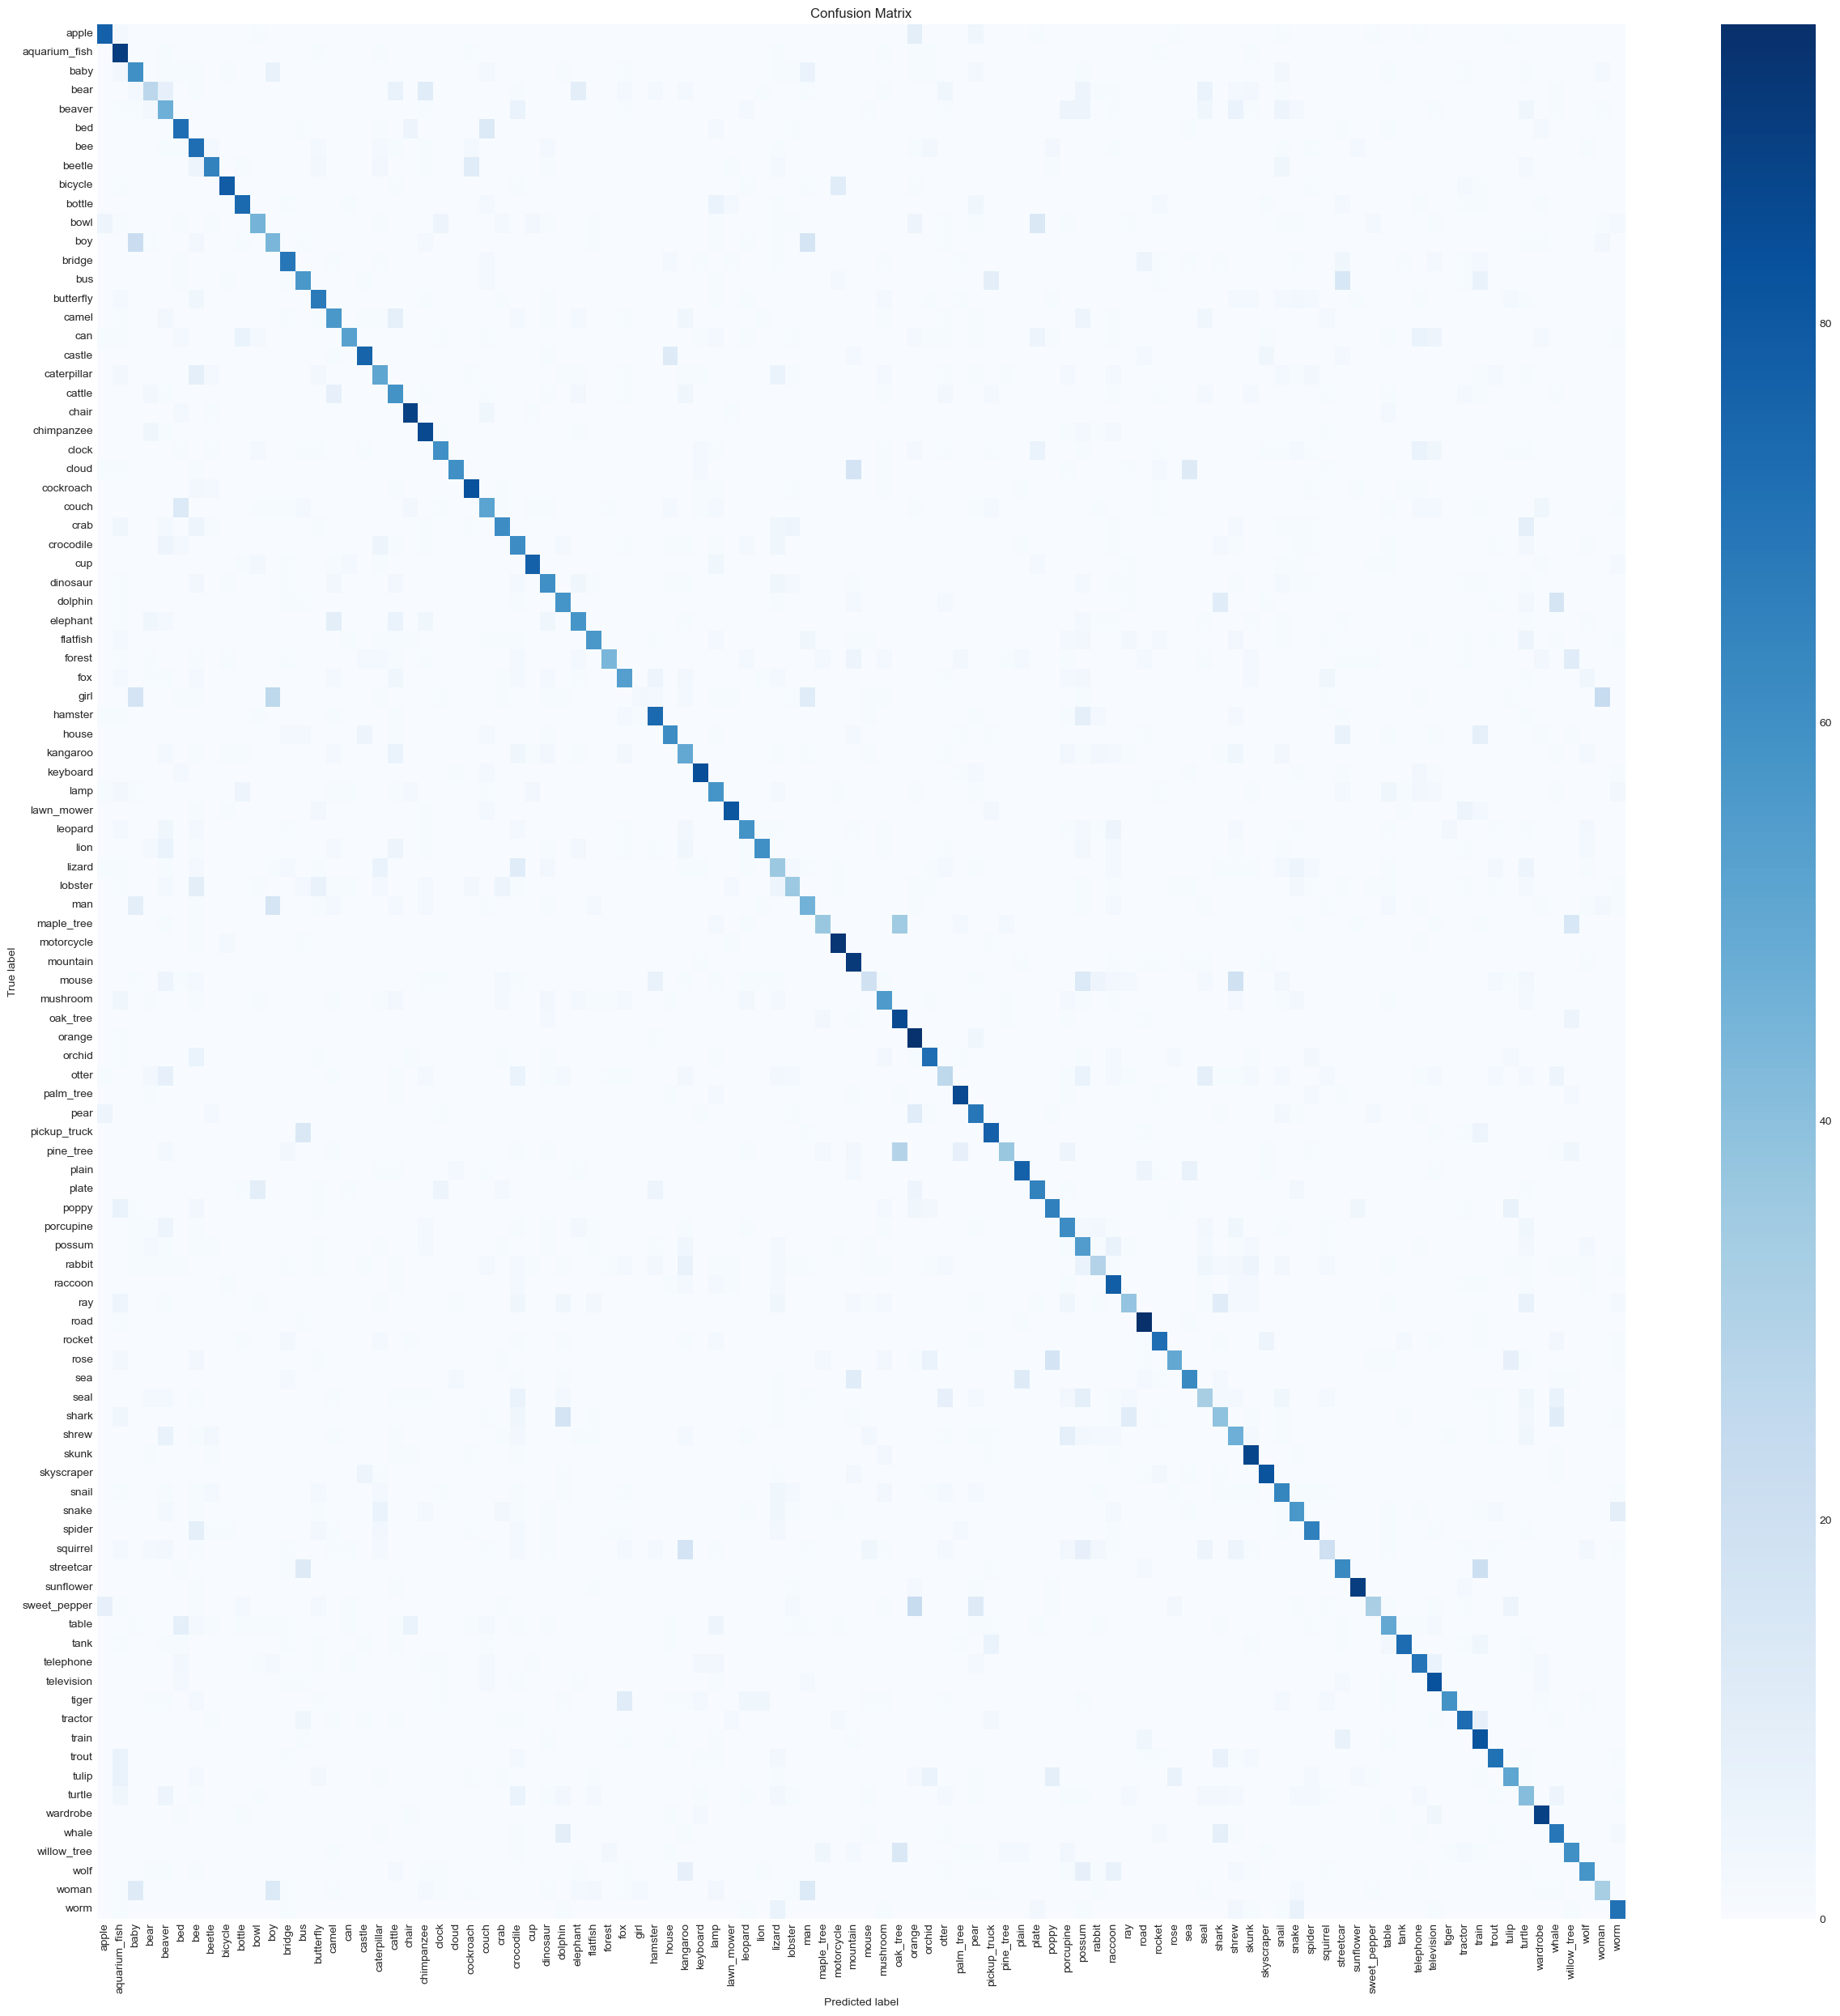


Searching for 25 misclassified images...


  0%|          | 0/79 [00:10<?, ?it/s]

Visualizing 25 misclassified images...
Misclassified images visualization saved to 1_CustomCNN_misclassified_25.png


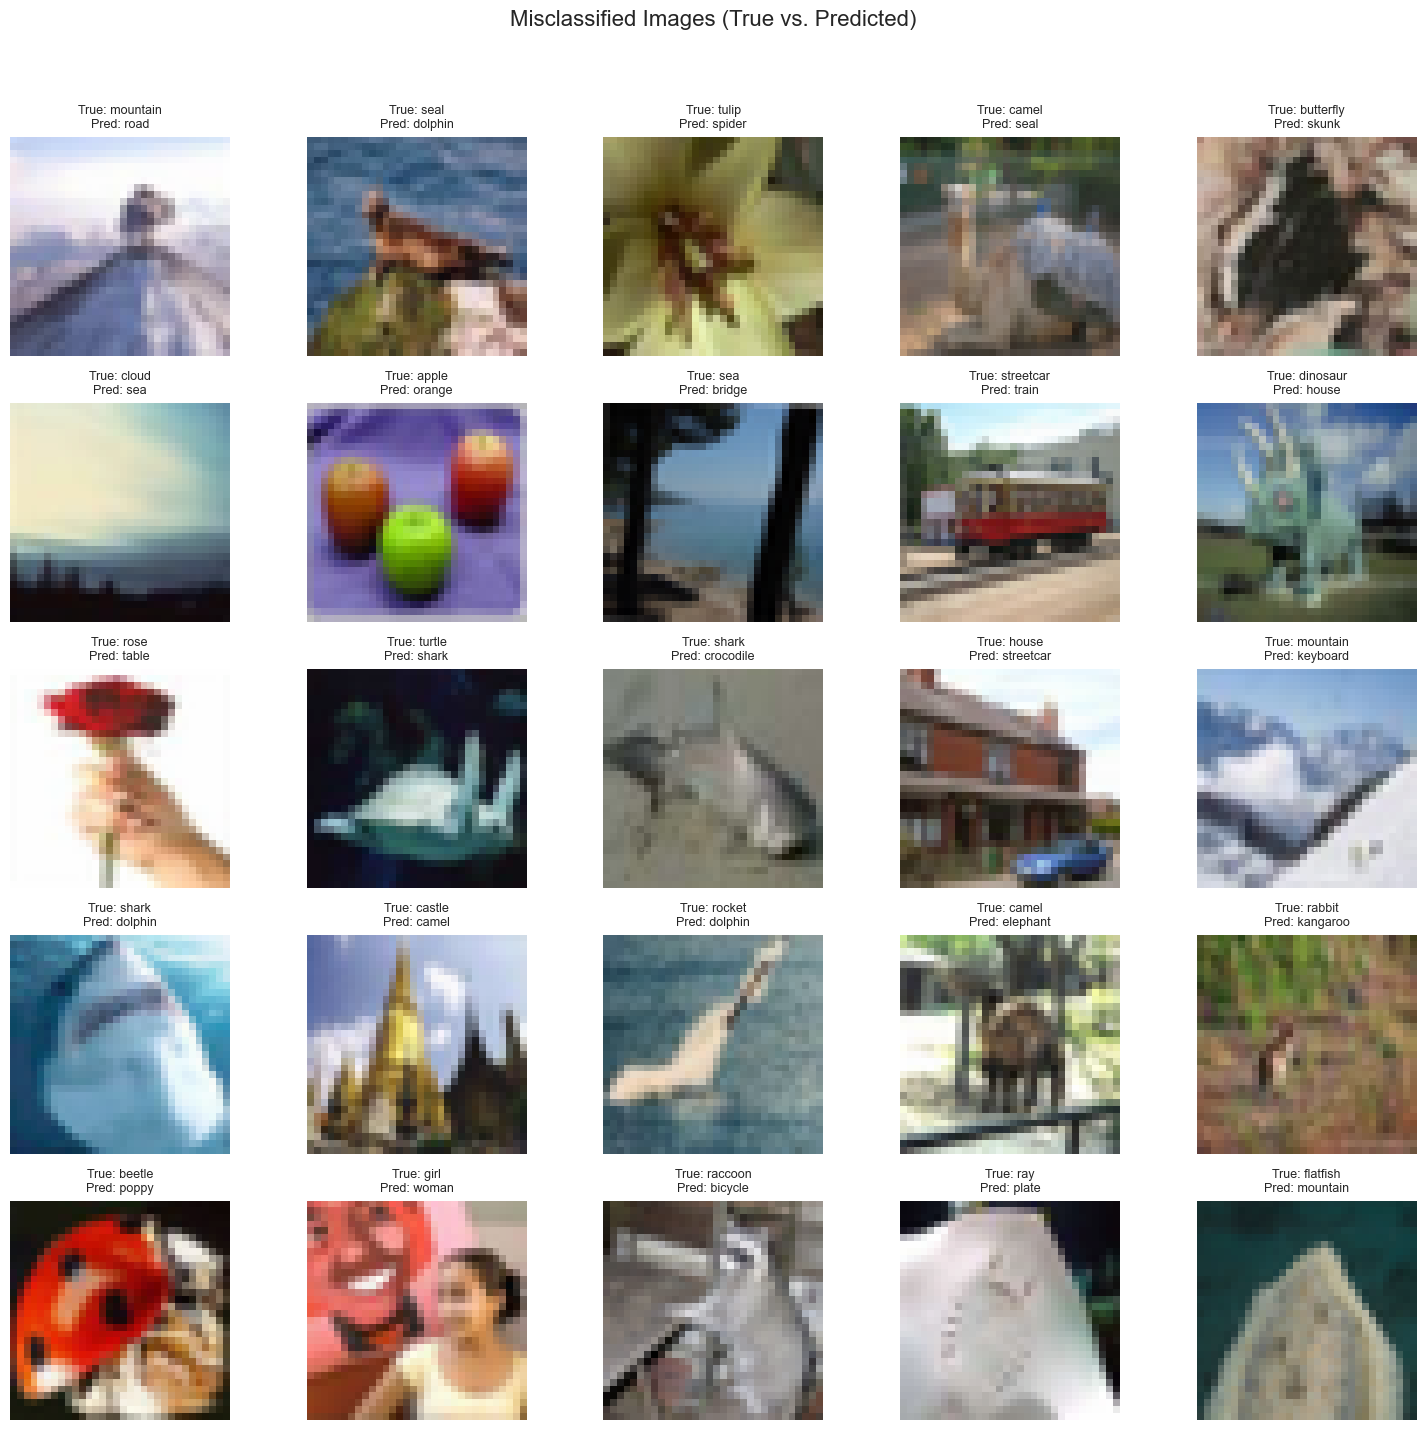

Accuracy history plot saved to 1_CustomCNN_accuracy_history.png


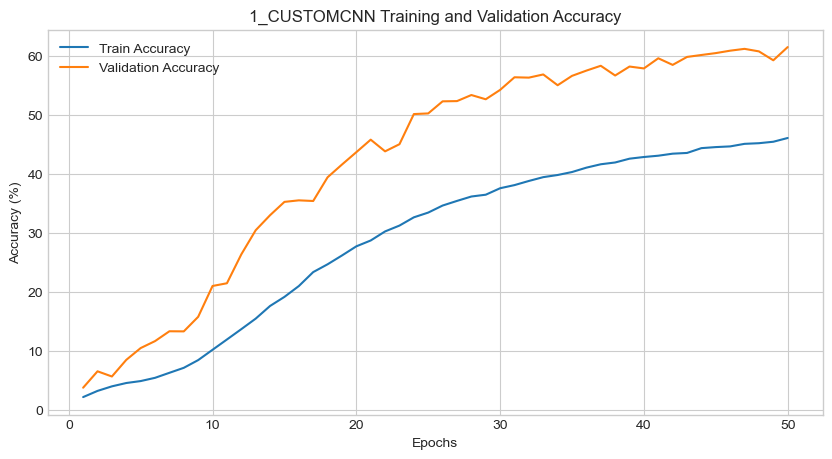

In [4]:
NUM_EPOCHS = 50
BATCH_SIZE = 128
LEARNING_RATE = 0.001
IMG_SIZE = 32          # Keep 32 for Custom CNN
USE_AUGMENTATION = True
DATA_DIR = './data_cifar100'
NUM_WORKERS = 4
MODEL_NAME = "1_CustomCNN" # Model name for saving files

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

# Get CIFAR-100 class names
class_names = get_cifar100_class_names(DATA_DIR)
num_classes = len(class_names)

print(f"Đang tải dữ liệu CIFAR-100 (Input size: {IMG_SIZE}x{IMG_SIZE})...")
train_loader, test_loader, _ = get_cifar100_loaders( # Use num_classes from class_names
    batch_size=BATCH_SIZE,
    data_dir=DATA_DIR,
    img_size=IMG_SIZE,
    use_augmentation=USE_AUGMENTATION,
    num_workers=NUM_WORKERS
)

if train_loader is None:
    print("Không thể tải dữ liệu. Kết thúc chương trình.")
    exit()

print("Khởi tạo Custom CNN model...")
# Pass the correct num_classes and input_size
model = CustomCNN(num_classes=num_classes, input_size=IMG_SIZE)

print("Bắt đầu huấn luyện Custom CNN...")
# Capture the returned model and histories
trained_model, train_history, test_history = train_model(
    model, train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, device, model_name=MODEL_NAME
)

# --- Final Evaluation and Visualization ---
print("\n--- Performing Final Evaluation on Test Set ---")
final_metrics = evaluate_model(trained_model, test_loader, device, num_classes, class_names)

# Plot Confusion Matrix
if 'confusion_matrix' in final_metrics:
    plot_confusion_matrix(final_metrics['confusion_matrix'], class_names,
                            filename=f'{MODEL_NAME}_confusion_matrix.png',
                            figsize=(25, 25)) # Adjust size if needed

# Visualize Misclassified Images
visualize_misclassified(trained_model, test_loader, device, class_names,
                        num_images=25, # Number of images to show
                        filename_prefix=f'{MODEL_NAME}_misclassified')

# Plot Training/Validation Accuracy History
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_history, label='Train Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), test_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title(f'{MODEL_NAME.upper()} Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(f'{MODEL_NAME}_accuracy_history.png')
print(f"Accuracy history plot saved to {MODEL_NAME}_accuracy_history.png")
plt.show() # Uncomment to display plots immediately